# 4. Supervised Classification: LeNet-5 with PyTorch and FiftyOne Datasets

While zero-shot classification with CLIP is powerful, building and training a model from scratch is a fundamental skill. In this notebook, we'll implement **LeNet-5**, one of the earliest and most influential Convolutional Neural Networks (CNNs). We will train it on the MNIST training dataset using PyTorch.

**Key concepts covered:**
*   LeNet-5 architecture defined with a custom `nn.Module` in PyTorch
*   Splitting FiftyOne data for training and validation
*   Creating custom PyTorch Datasets from FiftyOne views
*   Data normalization through mean/standard deviation
*   Using PyTorch DataLoaders
*   Implementing a training loop and model checkpointing

![](https://github.com/andandandand/fiftyone/blob/develop/docs/source/getting_started_experiences/Classification/assets/lenet_5_schematic.webp?raw=1)

## Setup
As always, we start with imports and helper functions.

In [1]:
import os
import random
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset
from torch.optim import Adam

import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.random as four
import albumentations as A

### Reproducibility
To ensure our training experiments are reproducible, we'll define a function to set random seeds for all relevant libraries.

In [2]:
def set_seeds(seed=51):
    """Sets seeds for reproducibility."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    cv2.setRNGSeed(seed)
    try:
        A.seed_everything(seed)
    except AttributeError:
        pass
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        print("Warning: Some operations may not be deterministic")

def create_deterministic_training_dataloader(dataset, batch_size, shuffle=True, **kwargs):
    """Creates a DataLoader with deterministic behavior."""
    generator = torch.Generator()
    generator.manual_seed(51)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=generator if shuffle else None,
        **kwargs
    )

set_seeds(51)

## Defining the LeNet-5 Architecture

We'll define a modernized version of LeNet-5 using `ReLU` activations and `MaxPooling`, which generally perform better than the original `tanh` and `AveragePooling`.

In [3]:
class ModernLeNet5(nn.Module):
    """
    Modernized version of LeNet-5 with ReLU activations and max pooling.
    """

    def __init__(self, num_classes=10):
        super(ModernLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(Fun.relu(self.conv1(x)))
        x = self.pool(Fun.relu(self.conv2(x)))
        x = Fun.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = Fun.relu(self.fc1(x))
        x = self.dropout(x)  # Add dropout for regularization
        x = self.fc2(x)

        return x

## Preparing the Data

We'll now load the `train` split of MNIST and divide it into a training set (85%) and a validation set (15%). The validation set is crucial for monitoring overfitting and for saving the best version of our model during training.

In [4]:
train_val_dataset = foz.load_zoo_dataset("mnist",
                                         split='train',
                                         dataset_name="mnist-train-val",
                                         persistent=True)

# Ensure tags from previous runs are cleared
train_val_dataset.untag_samples(["train", "validation"])

set_seeds(51)
four.random_split(train_val_dataset,
                  {"train": 0.85, "validation": 0.15},
                  seed=51)

train_dataset = train_val_dataset.match_tags("train").clone(name="mnist-training-set", persistent=True)
val_dataset = train_val_dataset.match_tags("validation").clone(name="mnist-validation-set", persistent=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

100%|██████████| 9.91M/9.91M [00:27<00:00, 359kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 269kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 239kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.13MB/s]

   0% ||------------|     0/60000 [488.1us elapsed, ? remaining, ? samples/s] 

 100% |█████████████| 60000/60000 [18.5s elapsed, 0s remaining, 3.3K samples/s]      
Dataset info written to '/root/fiftyone/mnist/info.json'
Loading 'mnist' split 'train'
 100% |█████████████| 60000/60000 [30.6s elapsed, 0s remaining, 1.9K samples/s]      
Dataset 'mnist-train-val' created
Training samples: 51000
Validation samples: 9000


### Creating a Custom PyTorch Dataset

To use our FiftyOne datasets with PyTorch, we create a custom `Dataset` class. This acts as a bridge, allowing PyTorch's `DataLoader` to efficiently load images and labels while we still benefit from FiftyOne's powerful data management features.

In [5]:
class CustomTorchImageDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_dataset,
                 image_transforms=None,
                 label_map=None,
                 gt_field="ground_truth"):
        self.fiftyone_dataset = fiftyone_dataset
        self.image_paths = self.fiftyone_dataset.values("filepath")
        self.str_labels = self.fiftyone_dataset.values(f"{gt_field}.label")
        self.image_transforms = image_transforms

        if label_map is None:
            self.label_map = {str(i): i for i in range(10)}  # "0"->0, "1"->1, etc.
        else:
            self.label_map = label_map

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')

        if self.image_transforms:
            image = self.image_transforms(image)

        label_str = self.str_labels[idx]
        label_idx = self.label_map.get(label_str, -1)
        return image, torch.tensor(label_idx, dtype=torch.long)

### Data Normalization

Normalizing input data to have a mean of 0 and a standard deviation of 1 is a critical preprocessing step. It helps stabilize training and allows the model to converge faster. We'll compute these statistics on our training set and apply the same normalization to all splits.

In [6]:
def compute_stats_fiftyone(fiftyone_view):
    filepaths = fiftyone_view.values("filepath")
    all_pixels = []
    for filepath in tqdm(filepaths, desc="Computing Stats"):
        image = Image.open(filepath).convert('L')
        pixels = np.array(image, dtype=np.float32) / 255.0
        all_pixels.append(pixels.flatten())
    all_pixels = np.concatenate(all_pixels)
    return np.mean(all_pixels), np.std(all_pixels)

mean_intensity, std_intensity = compute_stats_fiftyone(train_dataset)
print(f"Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}")

# Define transforms with normalization
image_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

# Create label map and torch datasets
dataset_classes = sorted(train_val_dataset.distinct("ground_truth.label"))
label_map = {label: i for i, label in enumerate(dataset_classes)}

torch_train_set = CustomTorchImageDataset(train_dataset, label_map=label_map, image_transforms=image_transforms)
torch_val_set = CustomTorchImageDataset(val_dataset, label_map=label_map, image_transforms=image_transforms)

Computing Stats: 100%|██████████| 51000/51000 [00:07<00:00, 7247.29it/s]


Mean: 0.1318, Std: 0.3075


### PyTorch DataLoaders

`DataLoaders` wrap our datasets and handle batching, shuffling, and parallel data loading, which are essential for efficient training.

In [7]:
batch_size = 64
num_workers = os.cpu_count()

train_loader = create_deterministic_training_dataloader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)
print("DataLoaders created.")

DataLoaders created.


## Training the Model

We'll now set up the training loop. This involves defining a loss function, an optimizer, and functions to handle one epoch of training and validation.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ModernLeNet5().to(device)
optimizer = Adam(model.parameters(), lr=0.003)
ce_loss = nn.CrossEntropyLoss()

def train_epoch(model, train_loader, optimizer, ce_loss):
    model.train()
    batch_losses = []
    for images, labels in tqdm(train_loader, desc="Training"): 
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = ce_loss(logits, labels)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    return np.mean(batch_losses)

def val_epoch(model, val_loader, ce_loss):
    model.eval()
    batch_losses = []
    with torch.inference_mode():
        for images, labels in tqdm(val_loader, desc="Validation"): 
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = ce_loss(logits, labels)
            batch_losses.append(loss.item())
    return np.mean(batch_losses)

### The Training Loop with Checkpointing

We'll train for several epochs. Crucially, we will monitor the validation loss after each epoch and save the model's weights only when the validation loss improves. This practice, known as **checkpointing**, ensures we keep the model that generalizes best, protecting us from overfitting.

In [9]:
set_seeds(51)
num_epochs = 10
train_losses, val_losses = [], []
best_val_loss = float('inf')
model_save_path = Path(os.getcwd()) / 'best_lenet.pth'

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, ce_loss)
    val_loss = val_epoch(model, val_loader, ce_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)
        print('✓ Found and saved better model weights.')

Validation: 100%|██████████| 141/141 [00:08<00:00, 16.66it/s]


Epoch 1/10 - Train Loss: 0.2193 - Val Loss: 0.0831
✓ Found and saved better model weights.


Validation: 100%|██████████| 141/141 [00:08<00:00, 16.43it/s]


Epoch 2/10 - Train Loss: 0.0795 - Val Loss: 0.0614
✓ Found and saved better model weights.


Validation: 100%|██████████| 141/141 [00:08<00:00, 16.63it/s]


Epoch 3/10 - Train Loss: 0.0652 - Val Loss: 0.0657


Validation: 100%|██████████| 141/141 [00:08<00:00, 15.99it/s]


Epoch 4/10 - Train Loss: 0.0518 - Val Loss: 0.0576
✓ Found and saved better model weights.


Validation: 100%|██████████| 141/141 [00:08<00:00, 16.87it/s]


Epoch 5/10 - Train Loss: 0.0503 - Val Loss: 0.0509
✓ Found and saved better model weights.


Validation: 100%|██████████| 141/141 [00:08<00:00, 16.55it/s]


Epoch 6/10 - Train Loss: 0.0437 - Val Loss: 0.0723


Validation: 100%|██████████| 141/141 [00:08<00:00, 16.65it/s]


Epoch 7/10 - Train Loss: 0.0399 - Val Loss: 0.0597


Validation: 100%|██████████| 141/141 [00:08<00:00, 16.42it/s]


Epoch 8/10 - Train Loss: 0.0405 - Val Loss: 0.0595


Validation: 100%|██████████| 141/141 [00:08<00:00, 16.62it/s]


Epoch 9/10 - Train Loss: 0.0366 - Val Loss: 0.1150


Validation: 100%|██████████| 141/141 [00:08<00:00, 16.81it/s]

Epoch 10/10 - Train Loss: 0.0353 - Val Loss: 0.0666


### Visualizing Training Progress

Plotting the training and validation losses helps us diagnose the training process. In an ideal scenario, both losses decrease, and the validation loss remains close to the training loss. If the validation loss starts to increase while the training loss continues to decrease, the model is overfitting.

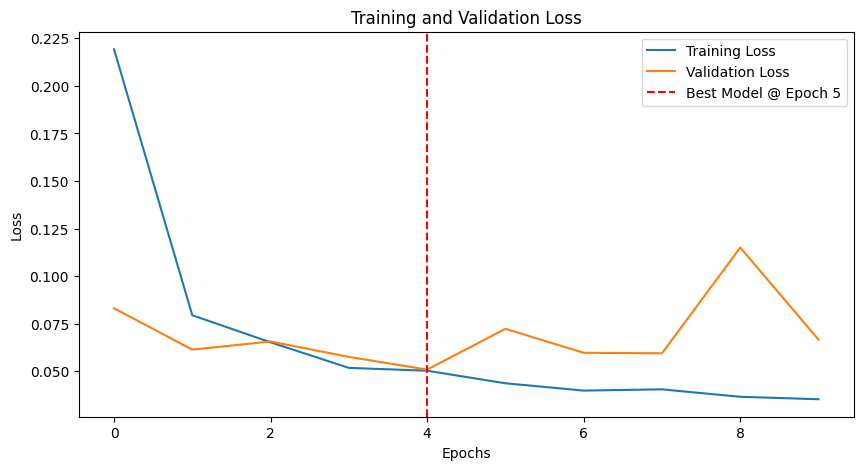

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
best_epoch = np.argmin(val_losses) + 1
plt.axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Model @ Epoch {best_epoch}')
plt.legend()
plt.show()

## Exercise

1. Try training a different variant of LeNet-5, closer to the original architecture, and use the [model comparison panel](https://docs.voxel51.com/user_guide/evaluation.html) to compare performance between the models. You can use the snippet of code below to define a "classic" LeNet-5. 

```python
class ClassicLeNet5(nn.Module):
    """
    LeNet-5 CNN architecture for MNIST digit classification.

    Original paper: "Gradient-Based Learning Applied to Document Recognition"
    by LeCun et al. (1998)

    Architecture (maintains original design with padding):
    Input (28x28) -> Pad to (32x32) -> C1 (6@28x28) -> S2 (6@14x14) ->
    C3 (16@10x10) -> S4 (16@5x5) -> C5 (120@1x1) -> F6 (84) -> Output (10)
    """

    def __init__(self, num_classes=10):
        super(ClassicLeNet5, self).__init__()

        # Feature extraction layers
        # C1: Convolutional layer - 6 feature maps, 5x5 kernels
        # Add padding=2 to convert 28x28 input to 32x32, maintaining original design
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)

        # S2: Subsampling layer (average pooling) - 2x2 with stride 2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C3: Convolutional layer - 16 feature maps, 5x5 kernels
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)

        # S4: Subsampling layer (average pooling) - 2x2 with stride 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C5: Convolutional layer - 120 feature maps, 5x5 kernels (original design)
        # This reduces the 5x5 feature maps to 1x1
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)

        # Classification layers
        # F6: Fully connected layer with 84 units
        self.fc1 = nn.Linear(120, 84)

        # Output layer: 10 classes for digits 0-9
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)

        Returns:
            Output logits of shape (batch_size, num_classes)
        """
        # C1: Convolution + activation (padding converts 28x28 to 32x32, then conv to 28x28)
        # Input: (batch, 1, 28, 28) -> Pad to (32, 32) -> Conv to (batch, 6, 28, 28)
        x = torch.tanh(self.conv1(x))

        # S2: Average pooling
        # Input: (batch, 6, 28, 28) -> Output: (batch, 6, 14, 14)
        x = self.pool1(x)

        # C3: Convolution + activation
        # Input: (batch, 6, 14, 14) -> Output: (batch, 16, 10, 10)
        x = torch.tanh(self.conv2(x))

        # S4: Average pooling
        # Input: (batch, 16, 10, 10) -> Output: (batch, 16, 5, 5)
        x = self.pool2(x)

        # C5: Convolution + activation (original 5x5 kernel design)
        # Input: (batch, 16, 5, 5) -> Output: (batch, 120, 1, 1)
        x = torch.tanh(self.conv3(x))

        # Flatten for fully connected layers
        # Input: (batch, 120, 1, 1) -> Output: (batch, 120)
        x = x.view(x.size(0), -1)

        # F6: Fully connected + activation
        # Input: (batch, 120) -> Output: (batch, 84)
        x = torch.tanh(self.fc1(x))

        # Output layer (no activation - raw logits)
        # Input: (batch, 84) -> Output: (batch, 10)
        x = self.fc2(x)

        return x

```

## Next Steps

We have successfully trained a LeNet-5 model and saved its best-performing weights.

Now, let's evaluate this model on the unseen test set to see how well it performs.

Proceed to `5_lenet_evaluation.ipynb`.